In [1]:
!pip install astral
!pip install skforecast==0.13.0
!pip install shap
!pip install catboost
!pip install ipython-autotime
!pip install scikit-optimize
!pip install ipython-autotime
!pip install tensorflow keras-tuner

%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00
time: 427 µs (started: 2025-05-19 07:06:31 +00:00)


In [2]:
# Data processing
# ==============================================================================

import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
# pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
# plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.model_selection import select_features
import shap
import time

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Version skforecast: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")
print(f"Version lightgbm: {lightgbm.__version__}")
print(f"Version xgboost: {xgboost.__version__}")
print(f"Version catboost: {catboost.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.5.0
Version xgboost: 2.1.4
Version catboost: 1.2.8
time: 27.6 s (started: 2025-05-19 07:06:31 +00:00)


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

time: 139 ms (started: 2025-05-19 07:06:58 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [29]:
from google.colab import files

# Tải tệp lên từ máy tính
uploaded = files.upload()

data = pd.read_excel('WT_data_after_preprocessing.xlsx')

# Hiển thị dữ liệu
print(data.head())

Saving WT_data_after_preprocessing.xlsx to WT_data_after_preprocessing (2).xlsx
                 Time           P  windspeed  wind direct   air temp  \
0 2022-11-05 14:00:00  274.000000   7.690833    59.300000  24.841667   
1 2022-11-05 18:00:00  259.583333   7.807500    78.308333  22.900000   
2 2022-11-05 22:00:00    0.000000   0.000000    92.500000  23.091667   
3 2022-11-05 23:00:00    0.000000   0.000000    92.500000  22.966667   
4 2022-11-06 00:00:00    0.000000   0.000000    92.500000  23.033333   

    humidity  irrad global horizontal  irrad plant of array     pressure  \
0  72.066667                   380.75                 366.0  1015.000000   
1  79.883333                     0.00                   0.0  1016.000000   
2  80.200000                     0.00                   0.0  1017.500000   
3  81.383333                     0.00                   0.0  1017.000000   
4  81.883333                     0.00                   0.0  1016.333333   

   rain fall  ...  wind direct

In [30]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(data['month'], cycle_length=12)
week_day_encoded = cyclical_encoding(data['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(data['hour'], cycle_length=24)



cyclical_features = pd.concat([
                        month_encoded,
                        week_day_encoded,
                        hour_day_encoded
                    ], axis=1)

data = pd.concat([data, cyclical_features], axis=1)
data.describe(include = 'all')

,Time,P,windspeed,wind direct,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,...,week,weekday,day_str,year_month,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,3508,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,...,3508.000000,3508.000000,3508,3508,3508.000000,3.508000e+03,3.508000e+03,3508.000000,3508.000000,3.508000e+03
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7,15,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Sun,2023_11,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,569,374,NaN,NaN,NaN,NaN,NaN,NaN
mean,2023-06-20 12:17:18.540478976,173.985080,6.419668,129.987486,25.834587,82.596522,129.678592,118.616554,1009.066534,0.000066,...,30.663911,4.061288,NaN,NaN,-0.123526,7.852763e-02,-4.206812e-03,0.033185,-0.101204,6.944543e-02
min,2022-11-05 14:00:00,0.000000,0.000000,10.102500,13.666667,48.558333,0.000000,0.000000,993.000000,0.000000,...,1.000000,1.000000,NaN,NaN,-1.000000,-1.000000e+00,-9.749279e-01,-0.900969,-1.000000,-1.000000e+00
25%,2023-03-08 20:45:00,77.332708,5.146875,75.731250,22.583333,78.993750,0.000000,0.000000,1003.000000,0.000000,...,19.000000,2.000000,NaN,NaN,-0.500000,-5.000000e-01,-7.818315e-01,-0.900969,-0.866025,-5.000000e-01
50%,2023-06-30 01:30:00,152.625000,6.296250,103.745833,26.500000,84.054167,0.216667,0.191667,1009.416667,0.000000,...,32.000000,4.000000,NaN,NaN,-0.500000,6.123234e-17,-2.449294e-16,-0.222521,-0.258819,6.123234e-17
75%,2023-09-24 18:15:00,263.479167,7.571042,194.250000,29.408333,88.000000,163.854167,152.037500,1014.416667,0.000000,...,45.000000,6.000000,NaN,NaN,0.500000,8.660254e-01,7.818315e-01,0.623490,0.707107,7.071068e-01
max,2024-01-01 23:00:00,473.916667,17.550000,353.916667,35.233333,94.000000,981.833333,966.333333,1027.583333,0.033333,...,52.000000,7.000000,NaN,NaN,1.000000,1.000000e+00,9.749279e-01,1.000000,1.000000,1.000000e+00


time: 98.3 ms (started: 2025-05-19 07:42:50 +00:00)


In [31]:
exog_features = data.columns
elements_to_remove = ['day_str',	'year_month',	'distance' , 'P','year','distance_to_smooth_curve', 'P_wind_bin', 'windspeed_bin','Q','S','Time',
 'month',
 'week',
 'hour',
 'weekday',
 'day']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 1.12 ms (started: 2025-05-19 07:42:55 +00:00)


In [32]:
exog_features

['windspeed',
 'wind direct',
 'air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 2.46 ms (started: 2025-05-19 07:42:56 +00:00)


*************************************************************************
**********************************P********************************
*************************************************************************


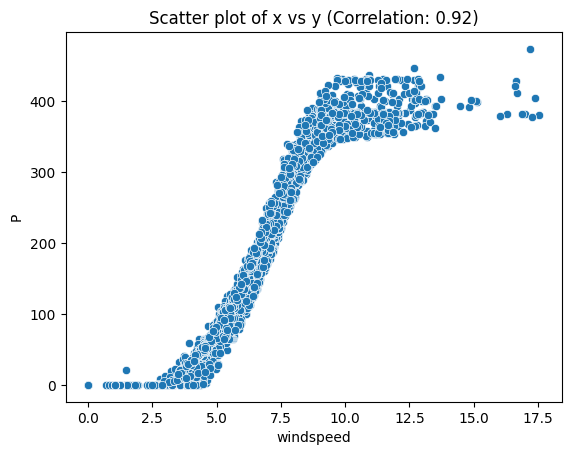

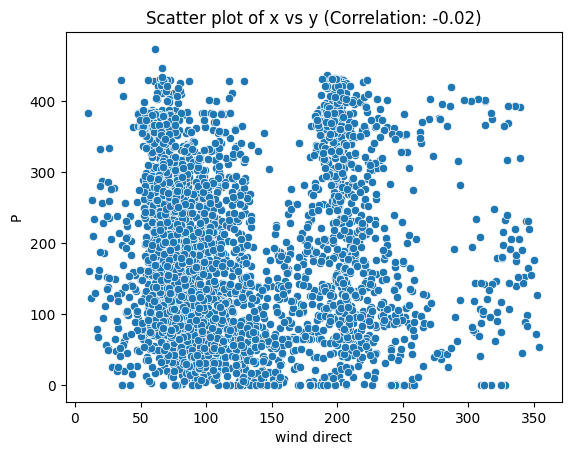

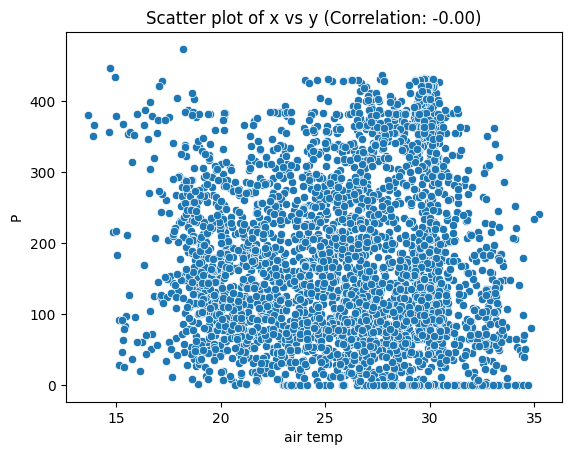

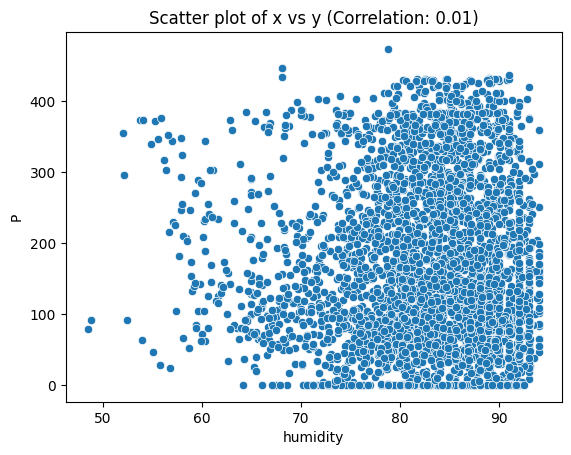

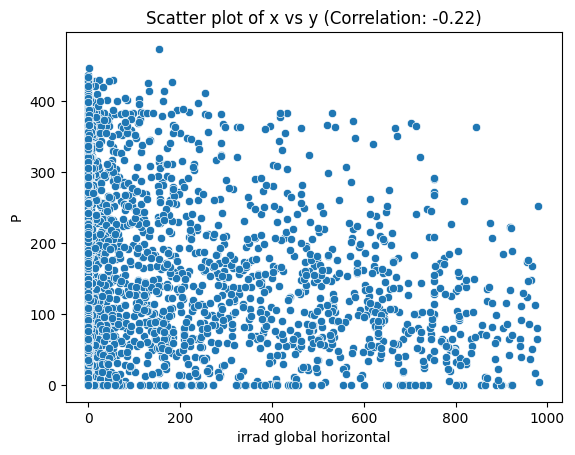

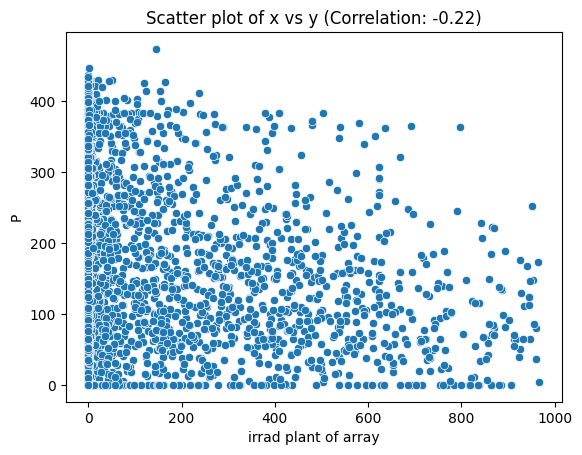

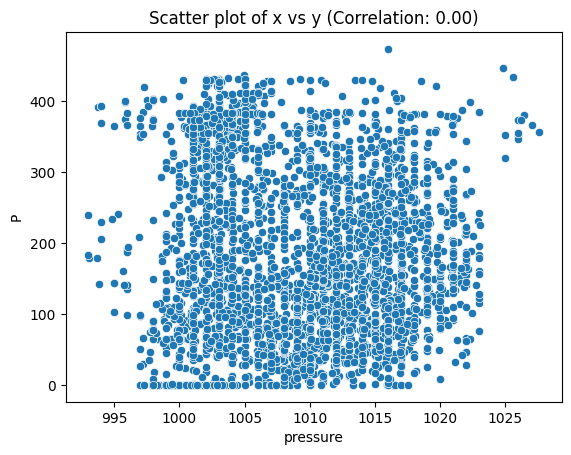

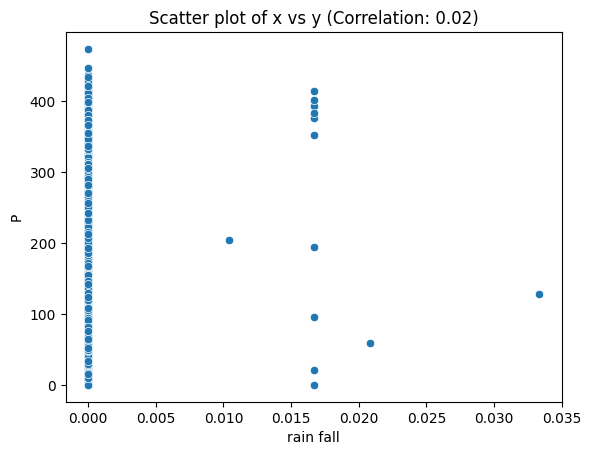

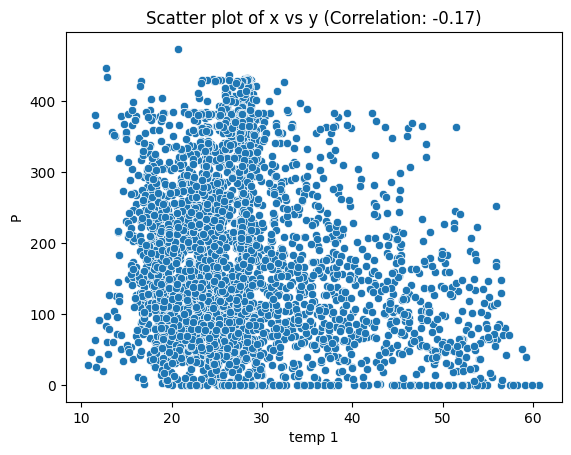

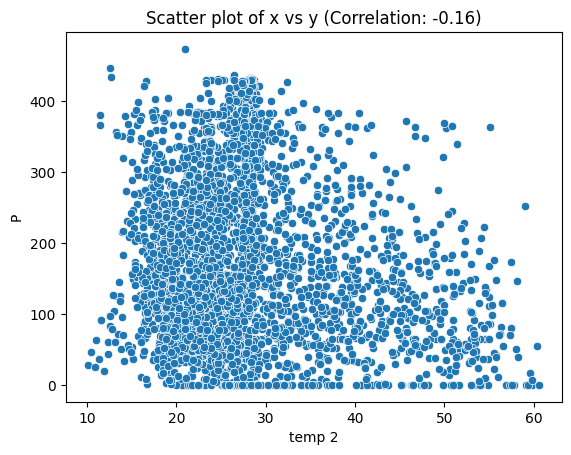

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide



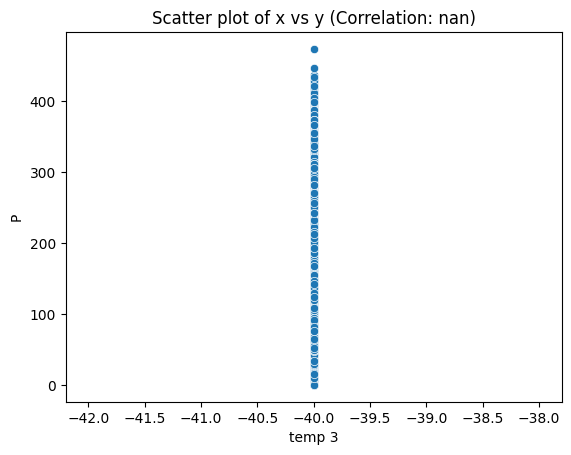

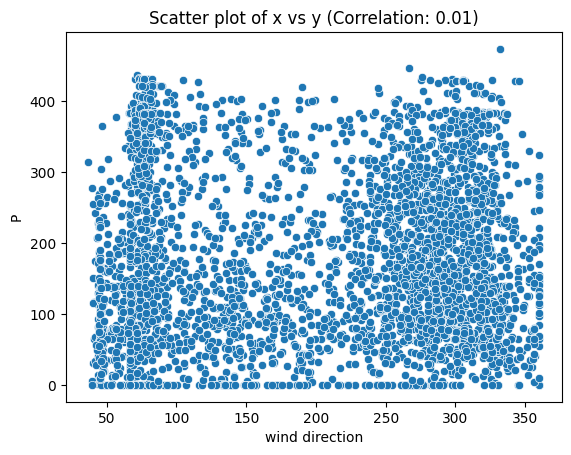

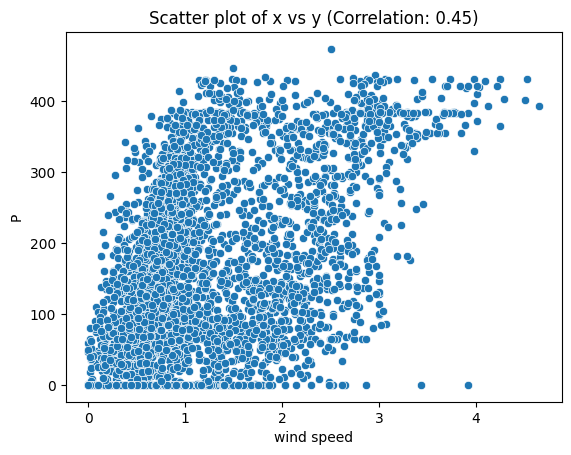

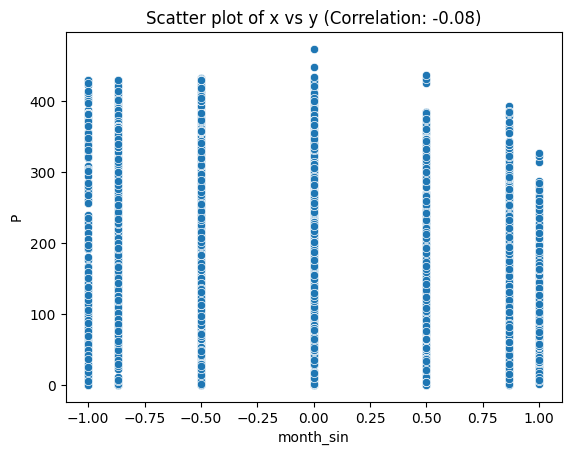

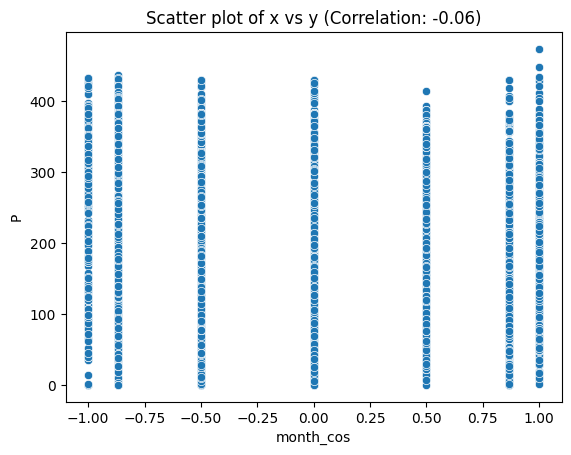

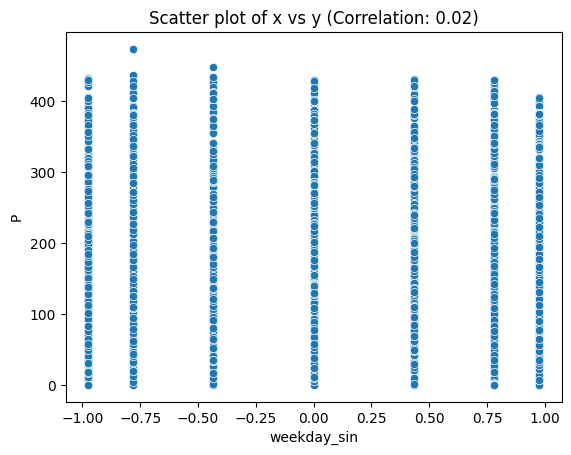

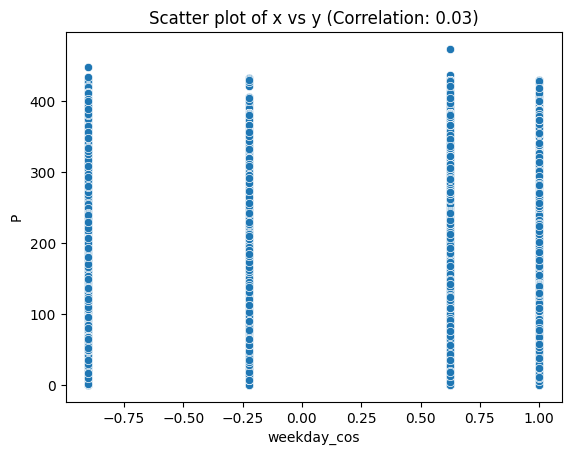

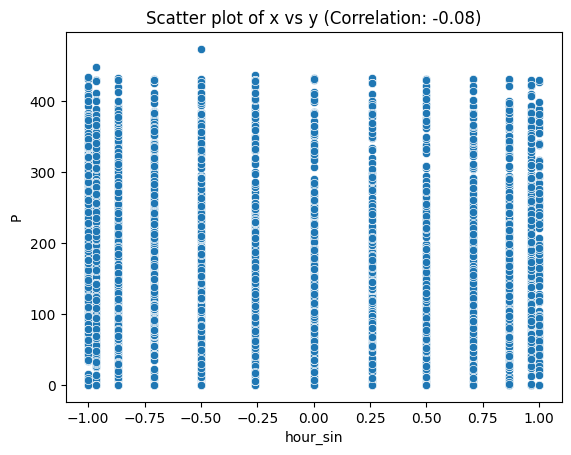

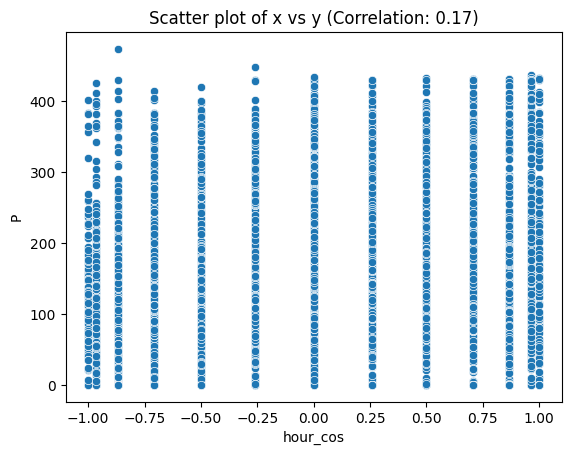

['windspeed', 'wind speed']
time: 3.78 s (started: 2025-05-19 07:42:58 +00:00)


In [33]:
target = 'P'
fe =[]
print("*************************************************************************")
print("**********************************"+target+"********************************")
print("*************************************************************************")
for i in exog_features:
    correlation = data[target].corr(data[i])
    # Vẽ biểu đồ
    sns.scatterplot(data=data, y=target, x=i)
    # Đặt tiêu đề với hệ số tương quan
    plt.title(f'Scatter plot of x vs y (Correlation: {correlation:.2f})')
    if abs(correlation)> 0.25: fe.append(i)
    plt.show()
print(fe)

# ALL

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[exog_features]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)


# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 37.7 ms (started: 2025-05-19 08:22:13 +00:00)


In [55]:
start_time = time.time()
search_spaces  = {
        'alpha'  : Real(1, 2.5),
        'solver' : Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'fit_intercept' : Categorical([True, False]),
    }

initial_model = Ridge(
                    random_state=123,
                )
initial_model.fit(X_train, y_train)
# Regressor hyperparameters search space
n_splits = 5  # Number of splits for cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv=cv_strategy   # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/

Best parameters found:  OrderedDict([('alpha', 1.6672487684517279), ('fit_intercept', False), ('solver', 'auto')])
Best cross-validation score:  -36.5728404308174
392.82150769233704
time: 6min 32s (started: 2025-05-19 08:22:18 +00:00)


In [56]:
best_model = Ridge(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)

print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.005118370056152344
Validation set mean absolute error: 35.04038335824658
169.46740657644824
167.34743914151753
167.34743914151753
time: 15.2 ms (started: 2025-05-19 08:30:47 +00:00)


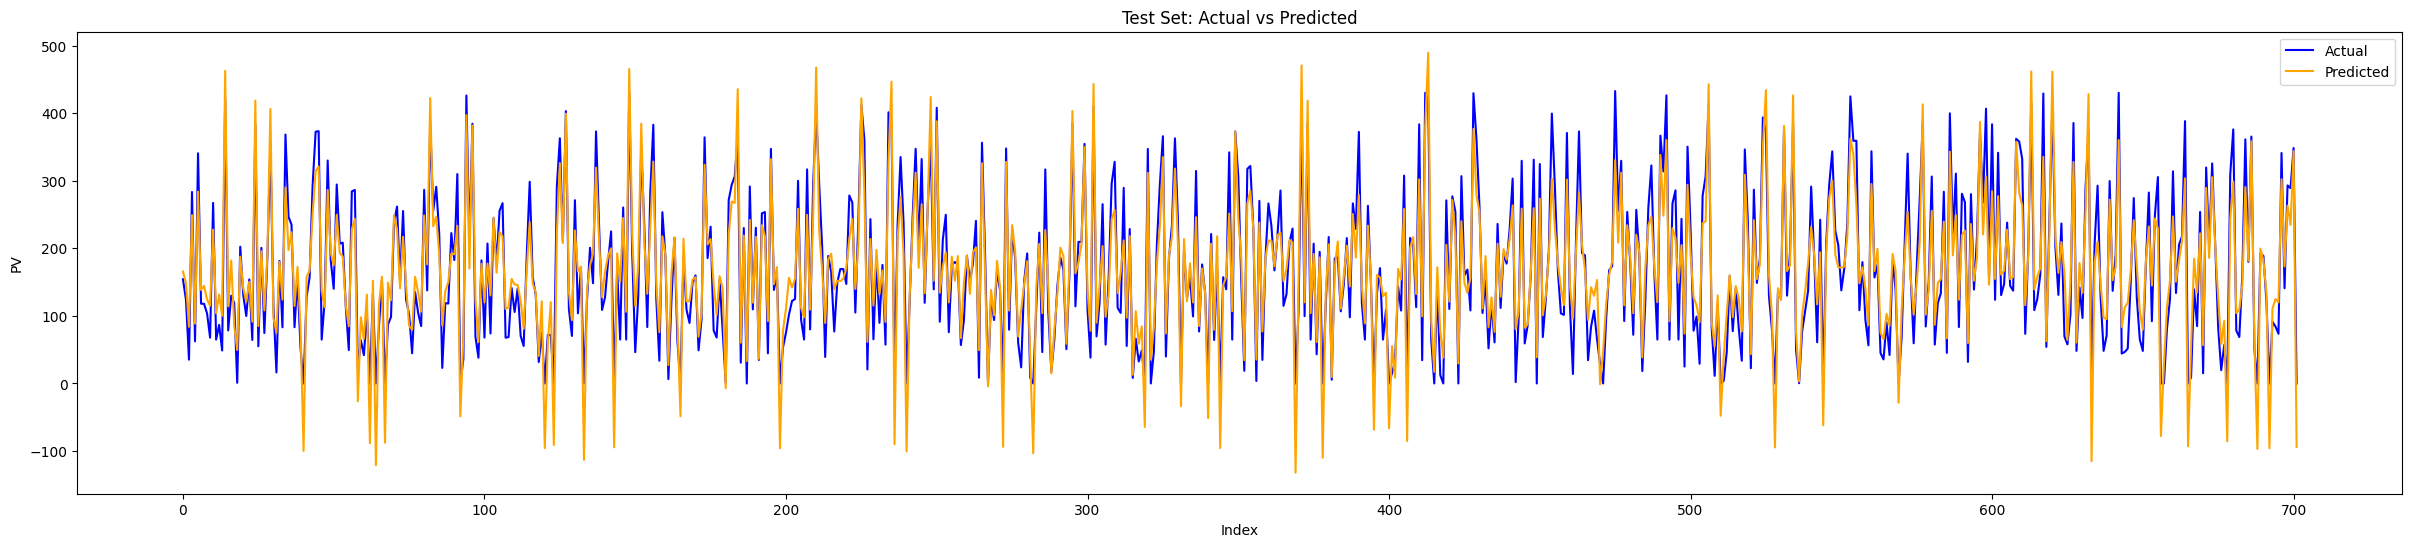

time: 552 ms (started: 2025-05-19 08:31:00 +00:00)


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 1830.0539854515757
RMSE: 42.7791302559037
MAE: 35.04038335824658
MAPE: inf%
Relative MAE: 20.67676851031502%
Relative RMSE: 25.24327899985043%
time: 6.11 ms (started: 2025-05-19 08:31:04 +00:00)


In [61]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/Ridge_wind_all_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.35 s (started: 2025-05-19 08:35:59 +00:00)


In [62]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/wind_Ridge_all.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.33 s (started: 2025-05-19 08:36:02 +00:00)


# Selected

In [63]:
from sklearn.model_selection import train_test_split
# Original split with ID tracking
X = data[fe]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)


# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 23.9 ms (started: 2025-05-19 08:38:54 +00:00)


In [64]:
start_time = time.time()
search_spaces  = {
        'alpha'  : Real(1, 2.5),
        'solver' : Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'fit_intercept' : Categorical([True, False]),
    }

initial_model = Ridge(
                    random_state=123,
                )
initial_model.fit(X_train, y_train)
# Regressor hyperparameters search space
n_splits = 5  # Number of splits for cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv= cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [1.0, np.True_, np.str_('auto')] before, using random point [1.4379096692486113, True, 'sparse_cg']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [1.0, np.True_, np.str_('auto')] before, using random point [2.0879197844599573, False, 'sparse_cg']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [1.0, np.True_, np.str_('auto')] before, using random point [1.6631306730833877, False, 'auto']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [1.0, np.True_, np.str_('svd')] before, using random point [1.1053404264536613, True, 'sparse_cg']

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWa

Best parameters found:  OrderedDict([('alpha', 1.0), ('fit_intercept', True), ('solver', 'saga')])
Best cross-validation score:  -38.01092369172186
276.64695286750793
time: 4min 36s (started: 2025-05-19 08:38:55 +00:00)


In [66]:
best_model = Ridge(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)

print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.002841472625732422
Validation set mean absolute error: 36.85279915655281
169.46740657644824
167.42797368556987
167.4278137253822
time: 14.4 ms (started: 2025-05-19 08:44:02 +00:00)


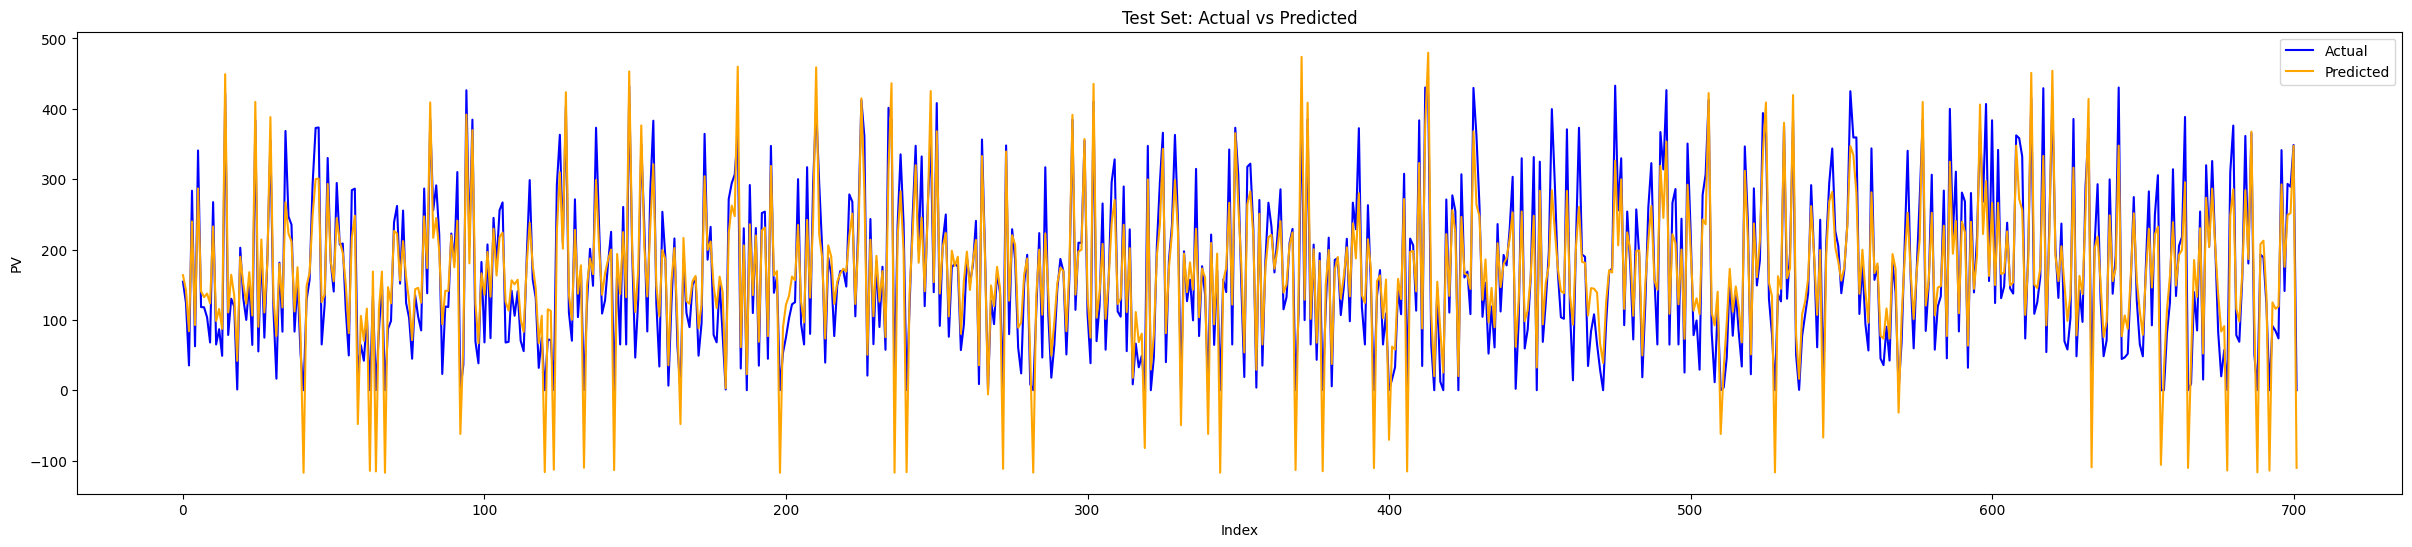

time: 330 ms (started: 2025-05-19 08:44:05 +00:00)


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 2057.321500392253
RMSE: 45.35770607506792
MAE: 36.85227883279144
MAPE: inf%
Relative MAE: 21.74593898453686%
Relative RMSE: 26.764855255282765%
time: 8.07 ms (started: 2025-05-19 08:44:08 +00:00)


In [69]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5_Results/Ridge_wind_selected_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.67 s (started: 2025-05-19 08:45:08 +00:00)


In [70]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5_Results/wind_Ridge_selected.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.49 s (started: 2025-05-19 08:45:10 +00:00)
